# Generate Noise PSD and SNR2 Weights

This notebook generates White Noise and Pink Noise PSDs, computes their SNR2 weights using a template, and compares them with the original MMC noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import os

# Ensure output directory exists
output_dir = Path("./")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# --- Paths ---
reusable_dir = Path("../../reusable")
config_path = reusable_dir / "PCA_config.yaml"
template_path = reusable_dir / "QP_template.npy"
mmc_psd_path = Path("/ceph/dwong/delight/noise_psd_xray.npy")

# --- Load Config ---
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)

sampling_frequency = cfg['sampling_frequency']
trace_samples = cfg['trace_samples']
noise_power = cfg.get('noise_power', 1.0) # Default to 1.0 if not specified

In [3]:
# --- Load Template ---
template = np.load(template_path).astype(np.float64)
# Ensure template matches trace_samples (padding or trimming if necessary, though expected to match)
if len(template) != trace_samples:
    # Simple truncation or zero-padding if needed, but warning is better
    print(f"Warning: Template length {len(template)} != trace_samples {trace_samples}")
    # Assuming template is correct for now or matches config

# Compute Template FFT
template_fft = np.fft.rfft(template) / sampling_frequency
freq = np.fft.rfftfreq(len(template), d=1.0 / sampling_frequency)
n_freq = len(freq)

In [4]:
# --- Noise Generation Functions ---
def get_noise_psd(f, noise_type='white'):
    spectra = {
        'white': lambda f: np.ones(len(f)),
        'pink': lambda f: 1/np.where(f == 0, float('inf'), f)
    }
    normalize = {
        'white': lambda f: 1. / (np.max(f) - np.min(f)),
        'pink': lambda f: 1. / (np.log(np.max(f)) - np.log(np.sort(f)[1]))
    }

    if noise_type not in spectra:
        raise ValueError(f"Unknown noise type: {noise_type}")
    
    # Calculate raw spectrum
    S = spectra[noise_type](f)
    
    # Normalize
    norm_factor = normalize[noise_type](f)
    
    # Scale by noise power (which matches variance in time domain ~ integral of PSD)
    return S * norm_factor * noise_power

# Generate PSDs
psd_white = get_noise_psd(freq, 'white')
psd_pink = get_noise_psd(freq, 'pink')

# Handle DC component (infinity in 1/f) - start from index 1 for plotting/calc
# Typically we might set DC to 0 or same as first bin for numerical stability
psd_pink[0] = psd_pink[1] # Simple fix for Inf at DC

In [5]:
# --- Load MMC Noise PSD ---
psd_mmc_arr = np.load(mmc_psd_path)
if psd_mmc_arr.ndim == 2 and psd_mmc_arr.shape[0] == 2:
    psd_mmc = psd_mmc_arr[1]
else:
    psd_mmc = psd_mmc_arr

# Interpolate MMC PSD to match current frequency bins if necessary
if len(psd_mmc) != n_freq:
    print(f"Resampling MMC PSD from {len(psd_mmc)} to {n_freq} bins")
    # Assuming linear spacing for both
    mmc_freq = np.linspace(0, sampling_frequency/2, len(psd_mmc))
    psd_mmc = np.interp(freq, mmc_freq, psd_mmc)

In [6]:
# --- Compute SNR2 Comparison ---
eps = 1e-18
snr2_mmc = (np.abs(template_fft) ** 2) / (psd_mmc + eps)
snr2_white = (np.abs(template_fft) ** 2) / (psd_white + eps)
snr2_pink = (np.abs(template_fft) ** 2) / (psd_pink + eps)

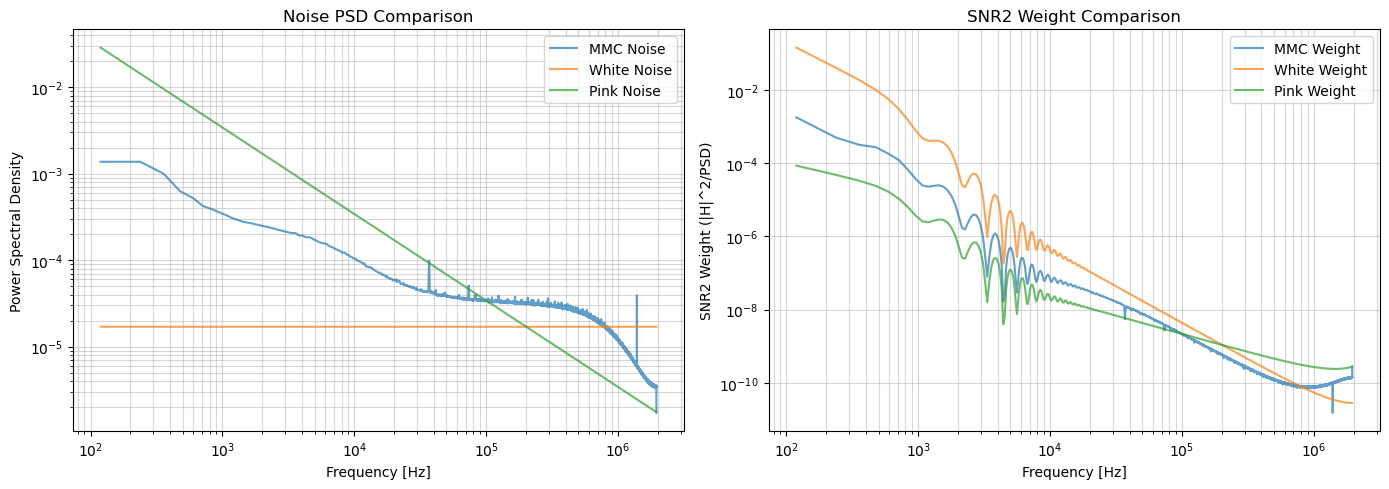

In [7]:
# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot PSDs
ax1.loglog(freq[1:], psd_mmc[1:], label='MMC Noise', alpha=0.7)
ax1.loglog(freq[1:], psd_white[1:], label='White Noise', alpha=0.7)
ax1.loglog(freq[1:], psd_pink[1:], label='Pink Noise', alpha=0.7)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Power Spectral Density')
ax1.set_title('Noise PSD Comparison')
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.5)

# Plot SNR2 Weights
ax2.loglog(freq[1:], snr2_mmc[1:], label='MMC Weight', alpha=0.7)
ax2.loglog(freq[1:], snr2_white[1:], label='White Weight', alpha=0.7)
ax2.loglog(freq[1:], snr2_pink[1:], label='Pink Weight', alpha=0.7)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('SNR2 Weight (|H|^2/PSD)')
ax2.set_title('SNR2 Weight Comparison')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.savefig("noise_psd_snr2_comparison.png")
plt.show()

In [8]:
# --- Save Outputs ---
np.save("noise_psd_white.npy", psd_white)
np.save("noise_psd_pink.npy", psd_pink)
np.save("snr2_weight_white.npy", snr2_white)
np.save("snr2_weight_pink.npy", snr2_pink)
np.save("noise_psd_mmc_resampled.npy", psd_mmc)
np.save("snr2_weight_mmc_resampled.npy", snr2_mmc)

print("Saved .npy files for White, Pink, and Resampled MMC noise PSDs and Weights.")

Saved .npy files for White, Pink, and Resampled MMC noise PSDs and Weights.
